In [273]:
import pandas as pd
import numpy as np
import networkx as nx 
import seaborn as sns
import math
import datetime

files_history = ["data/nltk/nltk_files_history.csv", "data/wagtail/wagtail_files_history.csv"]
commits_history = ["data/nltk/nltk_commits_history.csv", "data/wagtail/wagtail_commits_history.csv"]
files_columns = ["Repository", "Branches", "NbBranches", "OldFilePath", "FilePath", "FileName", "FileExtension", "FileType", 
                    "ChangeType", "NbMethods", "NbMethodsChanged", "NLOC", "Complexity", "NlocDivByNbMethods", 
                    "ComplexDivByNbMethods", "SATD", "SATDLine", "NbLinesAdded","NbLinesDeleted", "CommitId", "Author", "DateTime", 
                    "Date", "HourOfDay"]

files_pd = [pd.read_csv(file, header=None, names=files_columns) for file in files_history]
files_pd_all = pd.concat(files_pd)
files_pd_all["DateTime"] = pd.to_datetime(files_pd_all["DateTime"],format="%Y-%m-%d %H:%M:%S%z",utc=True)
files_pd_all["Date"]  = files_pd_all["DateTime"].dt.date
commits_pd = [pd.read_csv(file) for file in commits_history]

<AxesSubplot: >

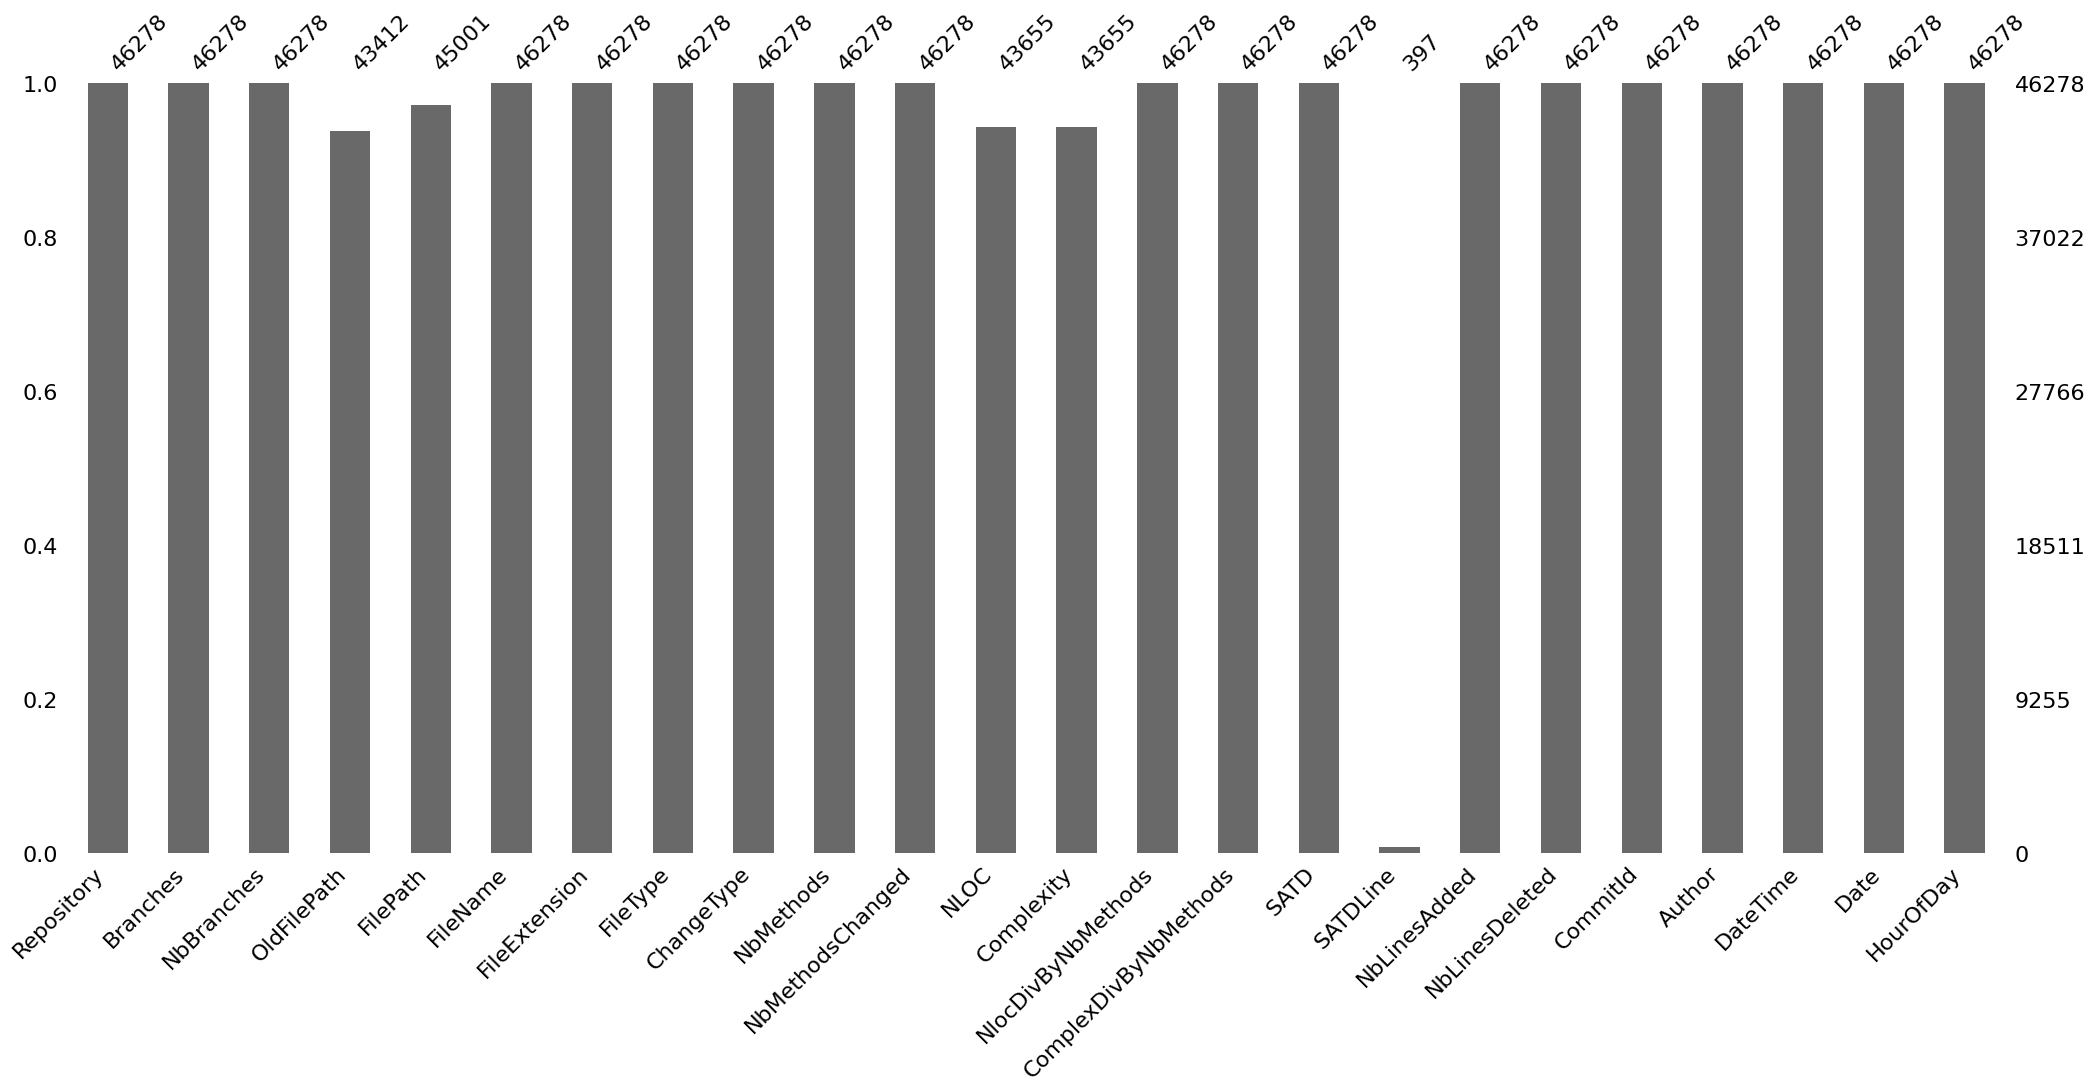

In [30]:
import missingno as msno

msno.bar(files_pd_all)

In [280]:
files_pd_all[["Repository", "Branches"]].drop_duplicates()

,Repository,Branches
0,nltk,{'develop'}
0,wagtail,{'main'}


In [281]:
files_pd_all[["Repository", "FileName"]].drop_duplicates().groupby(["Repository"]).size().reset_index(name="count")

,Repository,count
0,nltk,644
1,wagtail,1283


In [301]:
files_pd_all[["Repository", "ChangeType"]].groupby(["Repository", "ChangeType"]).size().reset_index(name="count")

,Repository,ChangeType,count
0,nltk,ADD,1034
1,nltk,DELETE,660
2,nltk,MODIFY,19702
3,nltk,RENAME,491
4,nltk,UNKNOWN,7
5,wagtail,ADD,2002
6,wagtail,DELETE,651
7,wagtail,MODIFY,20566
8,wagtail,RENAME,1163
9,wagtail,UNKNOWN,2


In [311]:
distributions = files_pd_all[["Repository", "Branches", "CommitId", "Author"] + files_columns[9:19]]

distributions_long = pd.melt(distributions, id_vars=["Repository",  "Branches", "CommitId", "Author"], value_vars=files_columns[9:19])

In [324]:
g = sns.FacetGrid(distributions_long, hue="Repository", col = "variable",  col_wrap = 3, sharex = False, sharey = False)
g.add_legend()
g.figure.set_size_inches(24, 12) 
g.map_dataframe(sns.histplot, x = "value").set(xscale="log")

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/var/data/python/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 9 (	) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


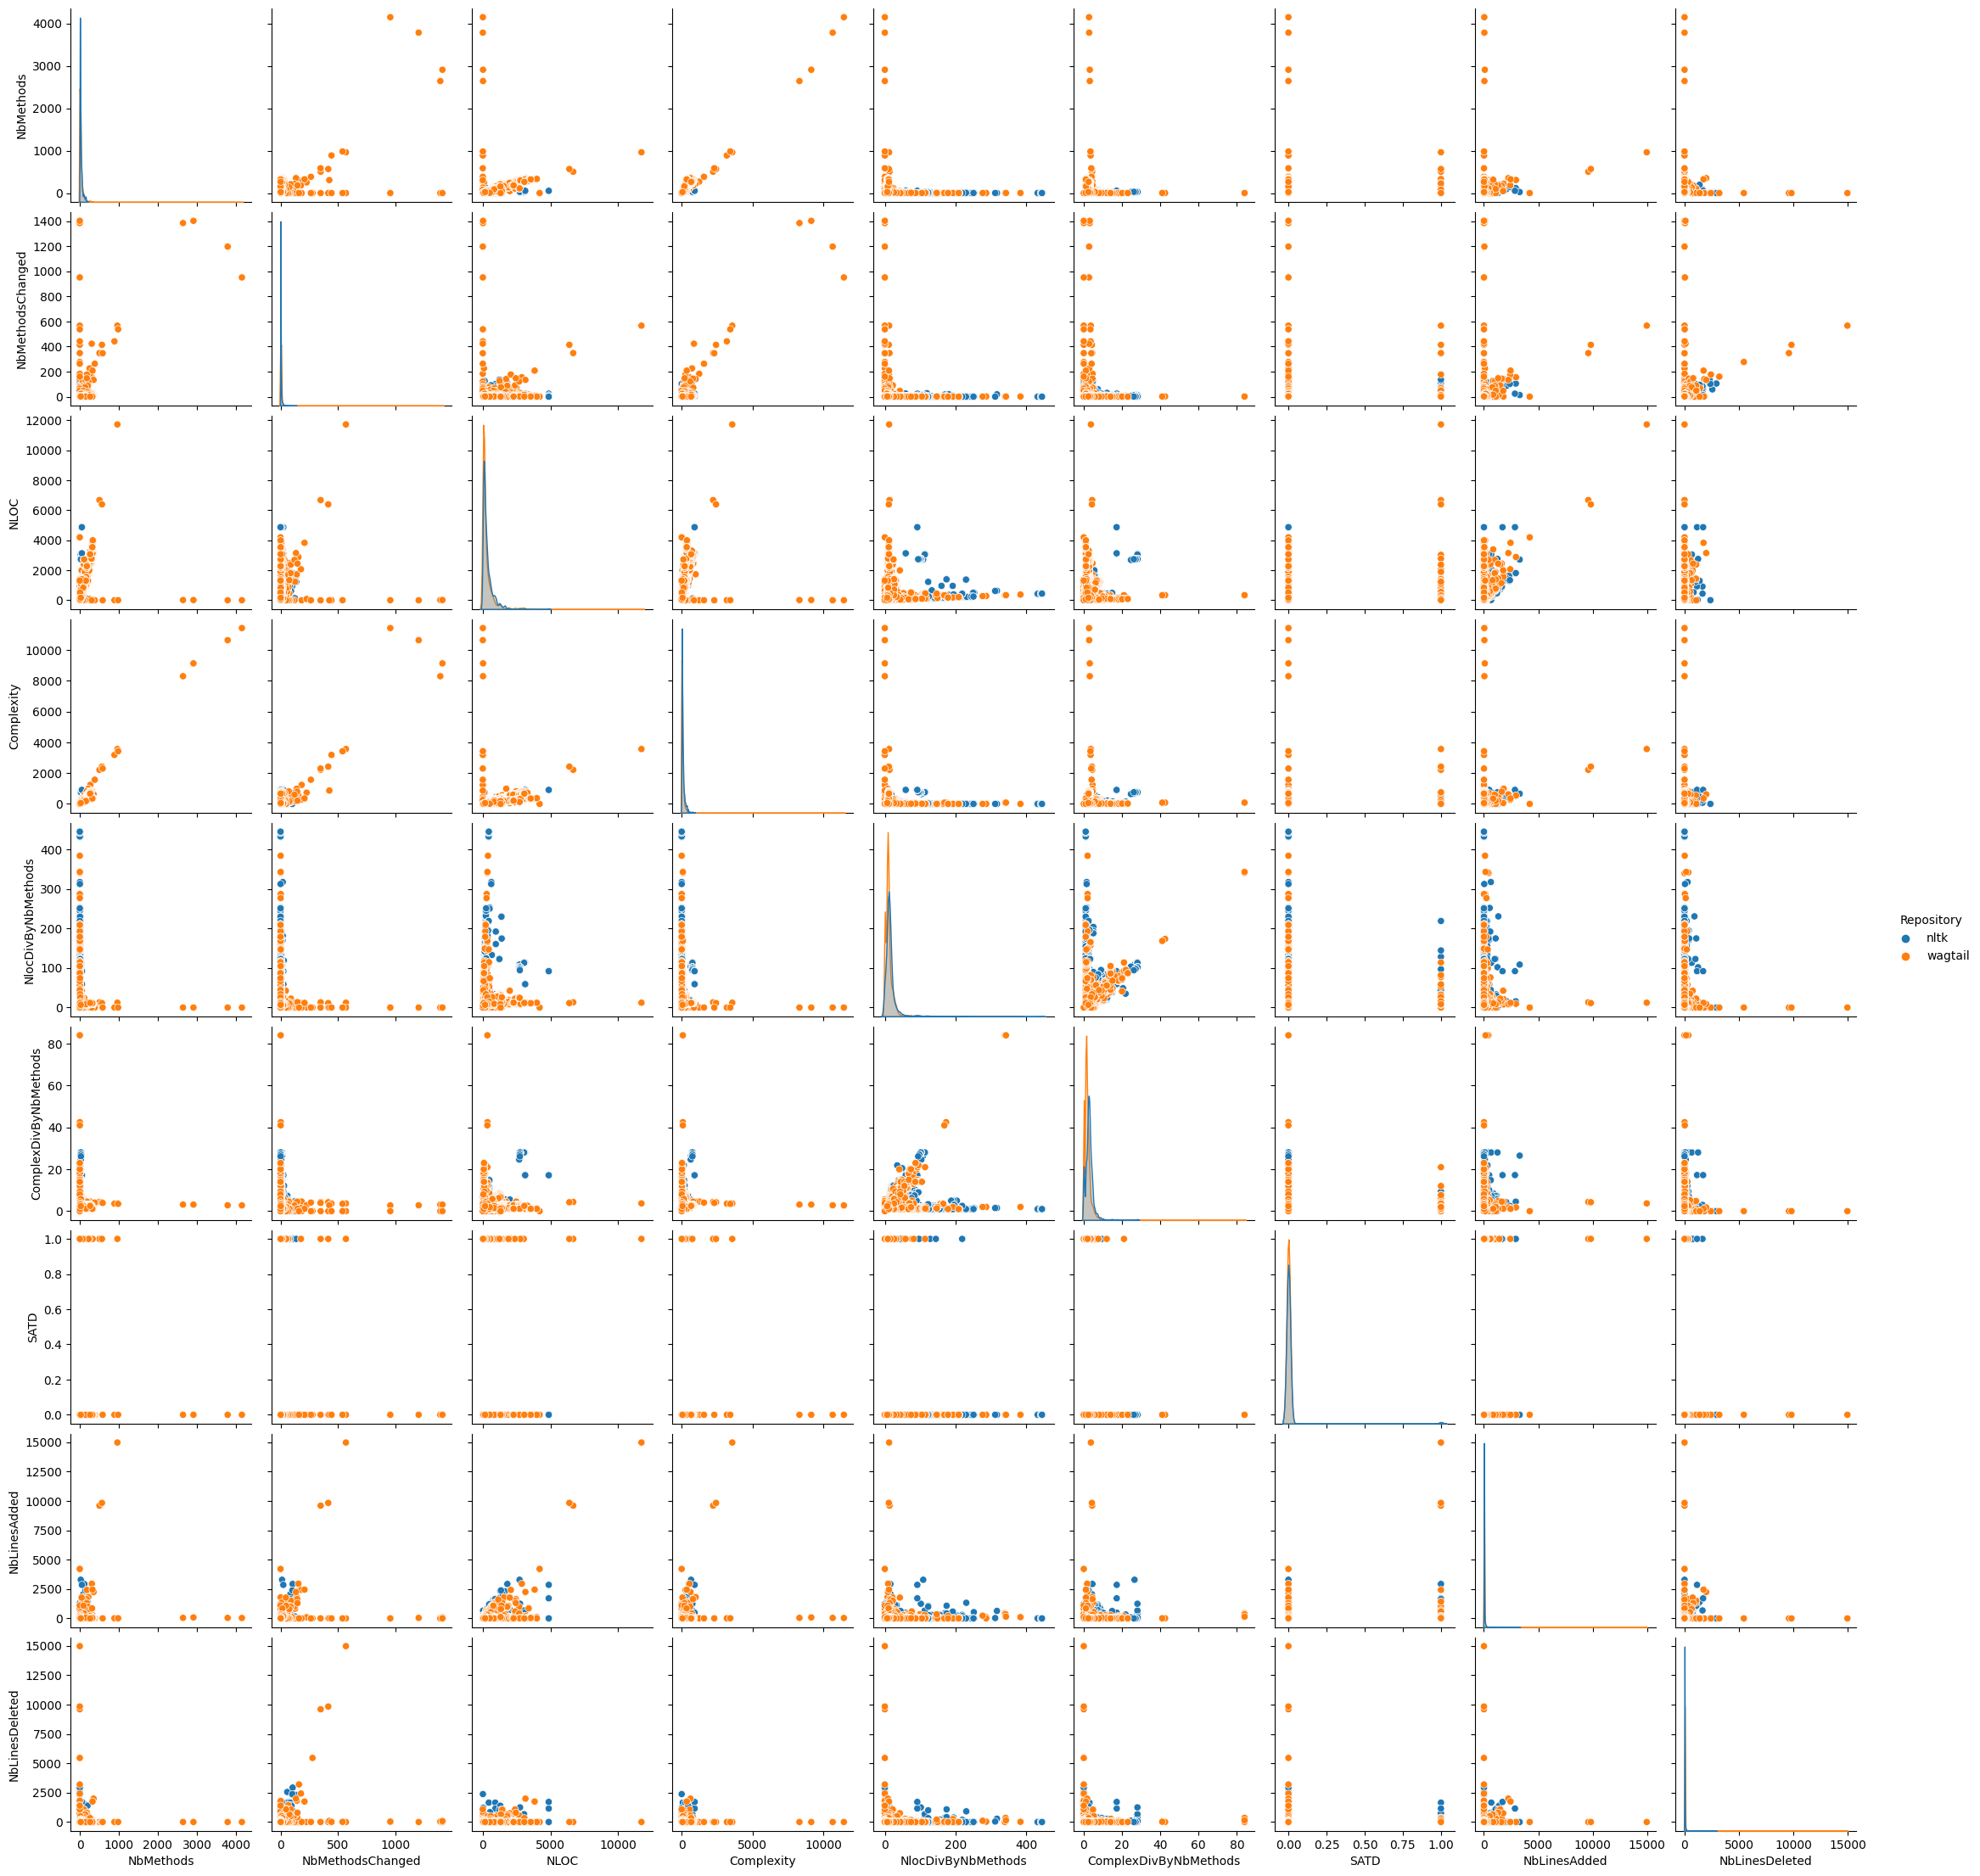

In [28]:
sns.pairplot(files_pd_all[["Repository"] + files_columns[9:19]].reset_index(drop=True), hue="Repository")

## Basic Exploration, File Changes over Time

In [21]:

commits_time = files_pd_all[["DateTime", "Repository", "ChangeType", "NbBranches"]]
commits_time["Week"] = commits_time["DateTime"].dt.floor("7D")
commits_time = commits_time.groupby(["Week", "Repository", "ChangeType"]).count().reset_index()

commits_time = commits_time.rename(columns = {"NbBranches": "count"})

/tmp/ipykernel_303/971838425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commits_time["Week"] = commits_time["DateTime"].dt.floor("7D")


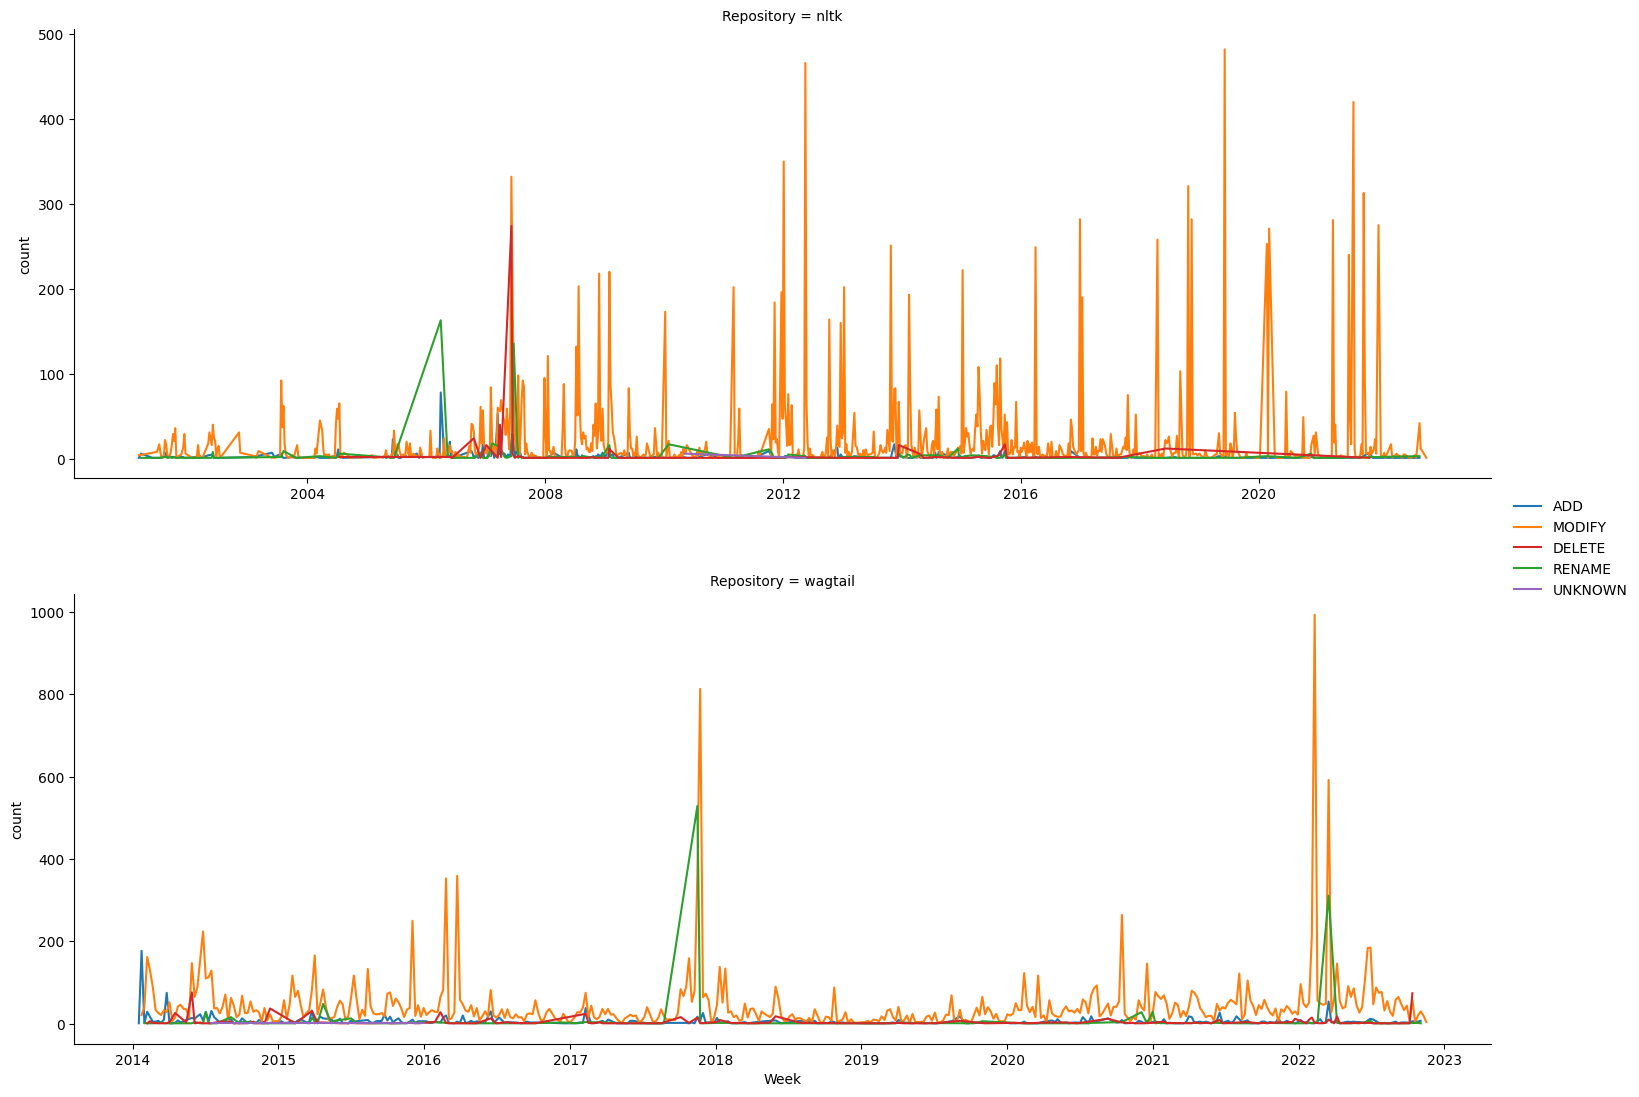

In [27]:

g = sns.FacetGrid(commits_time, col="Repository", col_wrap = 1, sharex = False, sharey = False)
g.map_dataframe(sns.lineplot, x="Week", y="count", hue = "ChangeType")
g.figure.set_size_inches(20, 12) 
g.add_legend()

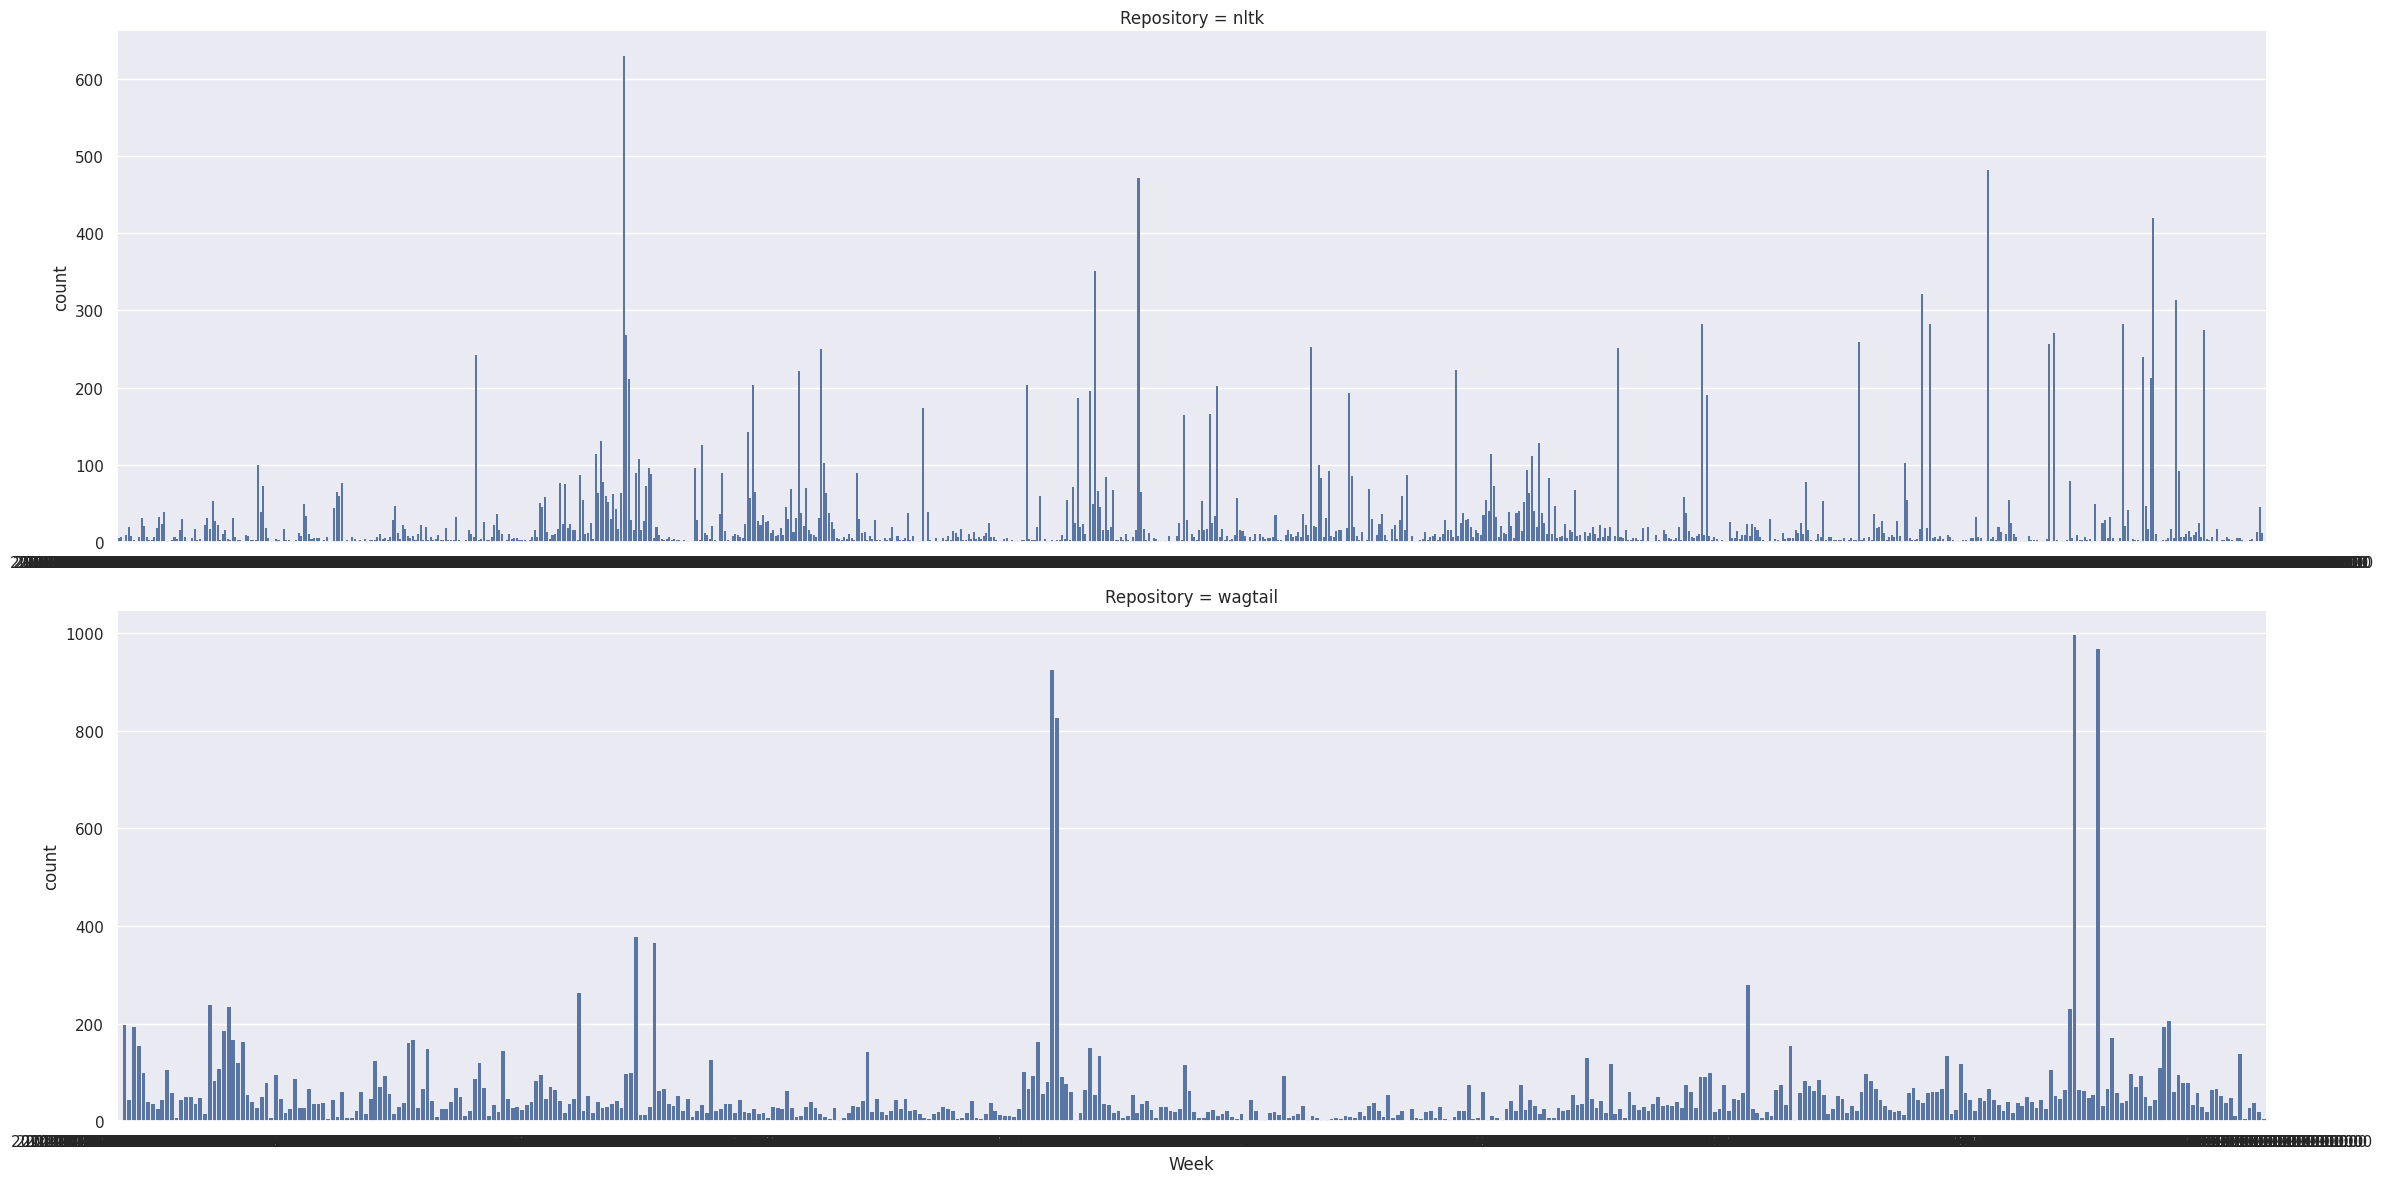

In [273]:
commits_week = files_pd_all
commits_week["Week"] = commits_week["DateTime"].dt.floor("7D")
commits_week = commits_week.groupby(["Week", "Repository"]).count().reset_index()
commits_week = commits_week[["Week", "Repository", "Branches"]] 
commits_week = commits_week.rename(columns = {"Branches": "count"})

g = sns.FacetGrid(commits_week, col="Repository",  col_wrap = 1, sharex = False, sharey = False)
g.figure.set_size_inches(24, 12) 
g.map_dataframe(sns.barplot, x="Week", y="count", lw=0)


## Commits by Author

In [257]:
def get_rank_grp_log10(df):
    df["rank"]  = df["count"].rank(ascending=False)
    df["rank"] = df["rank"].apply(lambda x: math.log10(x))
    df["count"] = df["count"].apply(lambda x: math.log10(x))
    return df

In [252]:
commits_contributor = files_pd_all.groupby(["Author", "Repository"]).size().reset_index(name="count")

commits_contributor_grp = commits_contributor.groupby(["Repository"])
commits_contributor_rank = [get_rank_grp_log10(df) for _, df in commits_contributor_grp]
commits_contributor_rank_all = pd.concat(commits_contributor_rank)

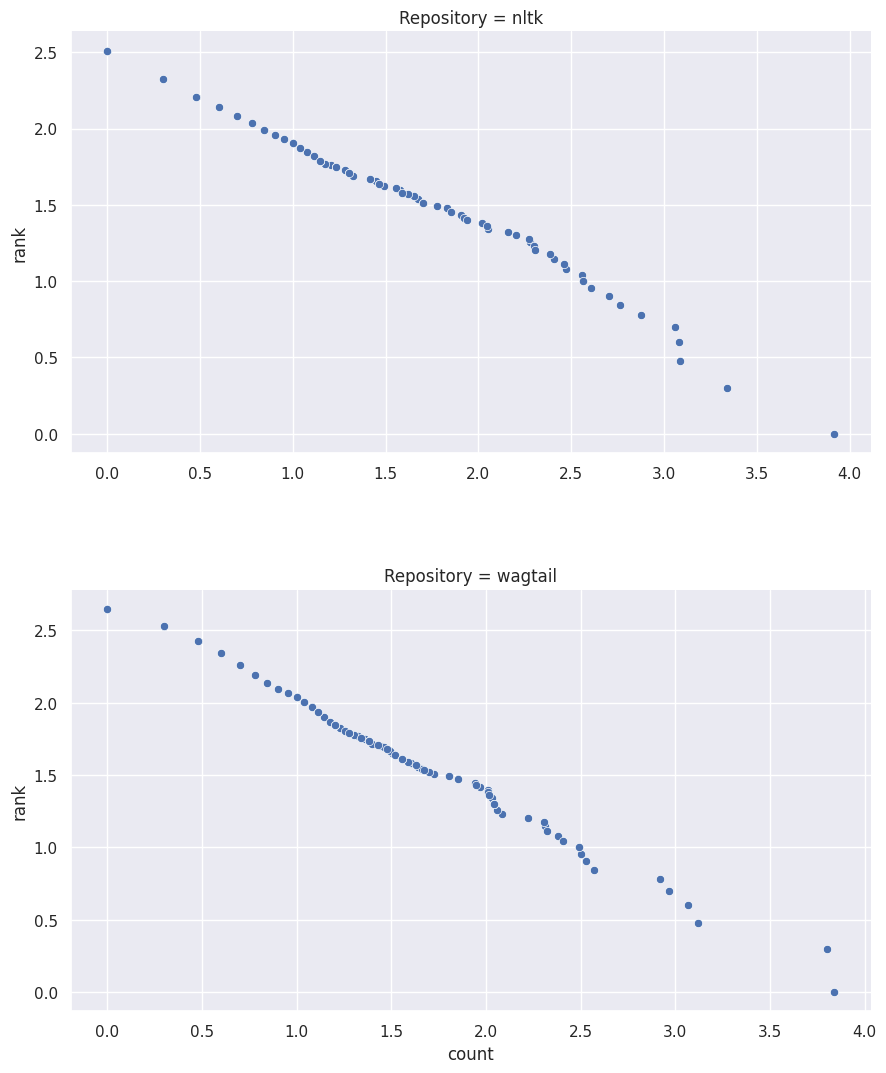

In [262]:
g = sns.FacetGrid(commits_contributor_rank_all, col="Repository",  col_wrap = 1, sharex = False, sharey = False)
g.map_dataframe(sns.scatterplot, x="count", y="rank", lw=0)
g.figure.set_size_inches(12, 12) 

# Plan

1. Create co-authorship graphs by file commit (commiting to the same file, within a certain time frame)
2. Count edges by time window, determine where it levels out (time to try - day, week, month, quarter)
3. Determine ideal time window, create graphs from this window
4. Extract network statistics for each timestep
5. Visualize these statistic over time

Note: Steps 3-5 can be done together (don't neceesarily need to create persistent graph objects)

In [217]:
import math

def rolling_with_name(df, nm, timescale):
    df = df.set_index('DateTime')
    df = df.sort_index()
    df = df[[ "FileName", "Author"]].drop_duplicates().dropna()
    df_rolled = df.rolling(timescale, min_periods = 1).count().reset_index()
    df_rolled["Repository"] = nm[0]
    df_rolled["FileName"] = nm[1]
    df_rolled = df_rolled.rename(columns = {"Author": "count"}, errors = "raise")
    df_rolled["total_edges"] =  df_rolled["count"].apply(lambda x: math.comb(int(x), 2))
    total_ts = df_rolled.groupby(["Repository", "DateTime"]).agg({"total_edges": "sum"}).reset_index()
    total_ts["timescale"] = int(timescale.replace("D", ""))
    return  total_ts

def timescale_count_contributors(df, timescale):
    df = df[["Repository", "DateTime", "FileName", "Author"]]
    df = df.drop_duplicates()
    #df = df.set_index(["DateTime"])
    df = df.sort_index()
    edge_counts_file = df.groupby(["Repository", "FileName"])
    edge_counts_rolling = [rolling_with_name(df, nm, timescale) for nm, df in edge_counts_file]
    return pd.concat(edge_counts_rolling)

In [222]:
time_intervals = ["1D", "3D", "7D", "14D", "30D", "60D", "90D"]
counts_by_time = [timescale_count_contributors(files_pd_all, interval) for interval in time_intervals]
counts_by_time_all = pd.concat(counts_by_time)

<AxesSubplot: xlabel='timescale', ylabel='total_edges'>

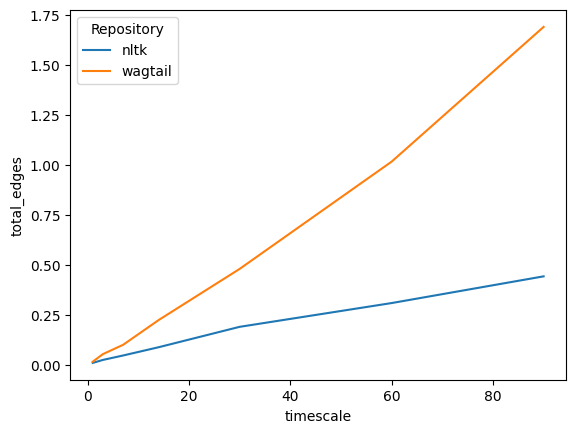

In [223]:
avg_counts_by_time_repo = counts_by_time_all.groupby(["timescale", "Repository"]).agg({"total_edges": "mean"}).reset_index()

sns.lineplot(x = "timescale", y = "total_edges", hue = "Repository", data = avg_counts_by_time_repo)


## BiPartite Graphs

In [328]:
import networkx as nx
from itertools import chain
from sklearn.linear_model import LinearRegression

def get_scaling_coeff_degree(degree_list):
    degree_list = [it[1] for it in degree_list]
    if len(degree_list) > 1:
        rank_order = [sorted(degree_list,  reverse=True).index(n) + 1 for n in degree_list]
        log_deg = np.array([math.log10(deg) for deg in degree_list]).reshape(-1, 1)
        log_rank = np.array([math.log10(ran) for ran in rank_order]).reshape(-1, 1)
        lm = LinearRegression()
        lm.fit(log_rank, log_deg)
        return lm.coef_[0][0]


def get_stats_nx_df(gr, grp):
    repo = grp[0]
    mon = grp[1]
    author_nodes = []
    file_nodes = []
    for idx, node_v in enumerate(gr.nodes(data=True)):
        if  node_v[1]['bipartite'] == 0:
            author_nodes.append(idx)
        else:
            file_nodes.append(idx)
    result_obj = {"repository": repo,
                    "month": mon,
                    "nodes": gr.number_of_nodes(), 
                    "edges": gr.number_of_edges(),
                    "nodes_author": len(author_nodes),
                    "nodes_files": len(file_nodes),
                    "density": nx.density(gr),
                    "zipf_scaling_degree_author": get_scaling_coeff_degree([list(gr.degree())[i] for i in author_nodes]),
                    "zipf_scaling_degree_file": get_scaling_coeff_degree([list(gr.degree())[i] for i in file_nodes]),
                    #"strong_components": nx.number_strongly_connected_components(gr),
                   #"weak_components": nx.number_weakly_connected_components(gr),
                   "average_clustering": nx.average_clustering(gr),
                   "degree_assort_coeff": nx.degree_assortativity_coefficient(gr),
                   #"avg_in_degree": sum([t[1] for t in gr.in_degree()]) / gr.number_of_nodes(),
                   #"avg_out_degree": sum([t[1] for t in gr.out_degree()]) / gr.number_of_nodes(),
                   #"n_nodes_in_cycles": len(set(chain(*nx.simple_cycles(gr))))
               #  "modularity": nx.algorithms.community.modularity(gr, nx.algorithms.community.greedy_modularity_communities(gr))
                    "maximal_cliques": nx.graph_number_of_cliques(gr)
    }
    return result_obj

def get_stats_nx_df_roll(gr, min_ts, repo):
    author_nodes = []
    file_nodes = []
    for idx, node_v in enumerate(gr.nodes(data=True)):
        if  node_v[1]['bipartite'] == 0:
            author_nodes.append(idx)
        else:
            file_nodes.append(idx)
    result_obj = {  "Date": min_ts,
                    "repository": repo,
                    "nodes": gr.number_of_nodes(), 
                    "edges": gr.number_of_edges(),
                    "nodes_author": len(author_nodes),
                    "nodes_files": len(file_nodes),
                    "density": nx.density(gr),
                    "zipf_scaling_degree_author": get_scaling_coeff_degree([list(gr.degree())[i] for i in author_nodes]),
                    "zipf_scaling_degree_file": get_scaling_coeff_degree([list(gr.degree())[i] for i in file_nodes]),
                    #"strong_components": nx.number_strongly_connected_components(gr),
                #"weak_components": nx.number_weakly_connected_components(gr),
                "average_clustering": nx.average_clustering(gr),
                "degree_assort_coeff": nx.degree_assortativity_coefficient(gr),
                #"avg_in_degree": sum([t[1] for t in gr.in_degree()]) / gr.number_of_nodes(),
                #"avg_out_degree": sum([t[1] for t in gr.out_degree()]) / gr.number_of_nodes(),
                #"n_nodes_in_cycles": len(set(chain(*nx.simple_cycles(gr))))
            #  "modularity": nx.algorithms.community.modularity(gr, nx.algorithms.community.greedy_modularity_communities(gr))
                    "maximal_cliques": nx.graph_number_of_cliques(gr)
    }
    return result_obj

def bi_stats(grp, df):
    distinct_file_author = df[["Author", "FilePath"]].drop_duplicates().dropna()
    author_nodes = distinct_file_author[["Author"]].drop_duplicates()["Author"].tolist()
    file_nodes = distinct_file_author[["FilePath"]].drop_duplicates()["FilePath"].tolist()
    g = nx.Graph()
    g.add_nodes_from(author_nodes,  bipartite=0)
    g.add_nodes_from(file_nodes,  bipartite=1)
    g.add_edges_from(list(distinct_file_author.itertuples(index=False, name=None)))
    return get_stats_nx_df(g, grp)


def bi_stats_roll(df, date_start, repo):
    df = df.reset_index()
    distinct_file_author = df[["Author", "FilePath"]].drop_duplicates().dropna()
    author_nodes = distinct_file_author[["Author"]].drop_duplicates()["Author"].tolist()
    file_nodes = distinct_file_author[["FilePath"]].drop_duplicates()["FilePath"].tolist()
    g = nx.Graph()
    g.add_nodes_from(author_nodes,  bipartite=0)
    g.add_nodes_from(file_nodes,  bipartite=1)
    g.add_edges_from(list(distinct_file_author.itertuples(index=False, name=None)))
    return get_stats_nx_df_roll(g,date_start, repo)



In [298]:
files_pd_all["month"] = files_pd_all["DateTime"].dt.to_period('M').dt.to_timestamp()
files_pd_grpd = files_pd_all.groupby(["Repository", "month"])

stats_time_repo = [bi_stats(grp, df) for grp, df in files_pd_grpd]
stats_time_repo_df = pd.DataFrame.from_dict(stats_time_repo)
stats_repo_time_long =  pd.melt(stats_time_repo_df, id_vars=['repository', "month"], value_vars=list(stats_time_repo_df.columns[2:]))

/tmp/ipykernel_282/4033975445.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  files_pd_all["month"] = files_pd_all["DateTime"].dt.to_period('M').dt.to_timestamp()
/var/data/python/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/var/data/python/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/var/data/python/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/var/data/python/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in do

KeyboardInterrupt: 

In [221]:
import altair as alt
from altair.expr import datum


alt.Chart(stats_repo_time_long).mark_line().encode(
    x='month',
    y='value'
).properties(
    width=800,
    height=300
).facet(
    row = "variable",
    column = 'repository'
).resolve_scale(
    x= 'independent',
    y = 'independent'
)

/var/data/python/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)

In [330]:
files_pd_all_repo = files_pd_all.groupby(["Repository"])

results = []
step_size = 30

for grp, df in files_pd_all_repo:
    date_range = pd.date_range(df["Date"].min(), df["Date"].max())
    df["Date"] = pd.to_datetime(df["Date"])
    for start_date in date_range[0:(len(date_range)-step_size)]:
        mask = (df['Date'] >= start_date) & (df['Date'] < start_date + datetime.timedelta(days=step_size))
        filtered_df = df.loc[mask]
        if filtered_df.shape[0] > 0:
            results.append(bi_stats_roll(filtered_df,start_date, grp))

/tmp/ipykernel_282/3847550327.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for grp, df in files_pd_all_repo:
/var/data/python/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/var/data/python/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/var/data/python/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/var/data/python/lib/python3.9/site-packages/networkx/algorithms/assor

In [331]:
stats_time_repo_rolling = pd.DataFrame.from_dict(results)
stats_repo_rolling_long =  pd.melt(stats_time_repo_rolling, id_vars=['repository', "Date"], value_vars=list(stats_time_repo_df.columns[2:]))

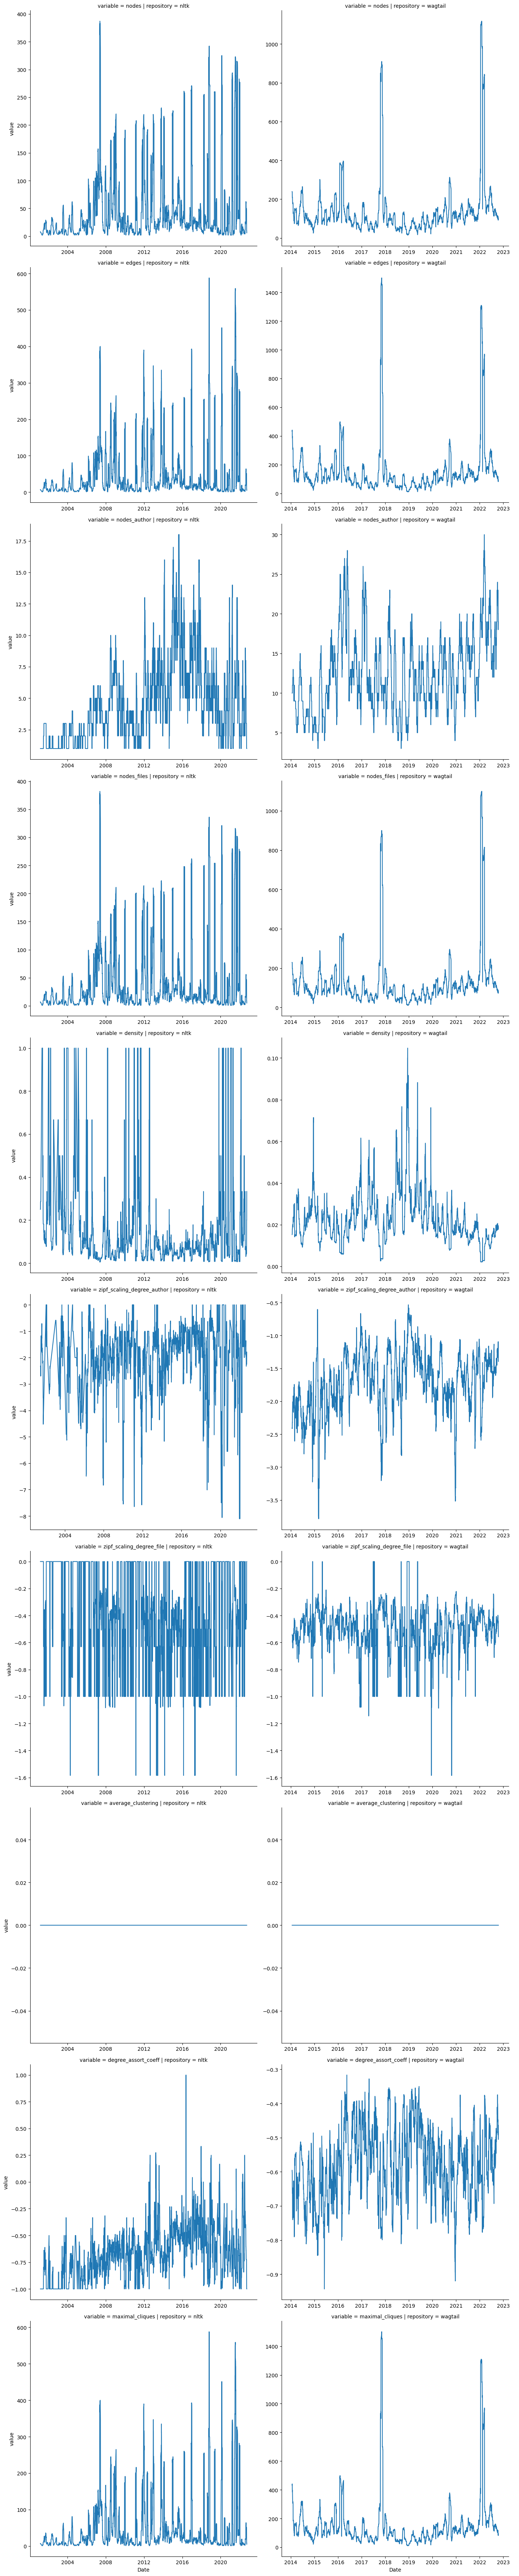

In [337]:
g = sns.FacetGrid(stats_repo_rolling_long, row = 'variable', col="repository", sharex=False, sharey=False, height = 7)
g.map_dataframe(sns.lineplot, x="Date", y="value")
g.add_legend()